On the last step of this project , i will move on with the classification.I will use three different supervised learning methods: Naive Bayesian Classifier , Support Vector Machines and Neural Networks.Lets import all of the needed dependencies first.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import keras
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [4]:
X=pd.read_csv('./data/preprocessed_final_data.csv',sep=',')
y=X['y']
X=X.drop(['y'],axis=1)

Since the minority class is only 11% of our dataset , this means it it going to be hard for our models to learn to classify it,thats why im going to use oversampling.
I will randomly select samples from the minority class and reproduce them in order for both classes to have the same number of records in the dataset.
This way i will help the supervised models to learn both classes.

In [5]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy="minority") #make minority class equal to majority
X,y=oversampler.fit_resample(X,y)

In order to continue with the classification process , we need to split our dataset into train and test datasets.I will use 30% of the dataset as the test size.

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

Now i will pass this data first to the Bayes Classifier.

In [7]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

GaussianNB()

Now our Gaussin Naive Bayes Classifier has been trained on the train dataset.
We need to see how well it will perform now on the test dataset , checking the accuracy and f1 score and the confusion matrix as well , in order to see how well it classifies each category.In order to do this we need the model to predict the output of the test dataset , and then compare it with the actual y_test (true output vs predicted output)

In [8]:
y_pred=gaussian.predict(X_test)

print("The Accuracy of the Gaussian Naive Bayes Classifier is : ",accuracy_score(y_test,y_pred))
print("The f1-score of the Gaussian Naive Bayes Classifier is : ",f1_score(y_test,y_pred))

The Accuracy of the Gaussian Naive Bayes Classifier is :  0.6777551127151001
The f1-score of the Gaussian Naive Bayes Classifier is :  0.5843060522231969


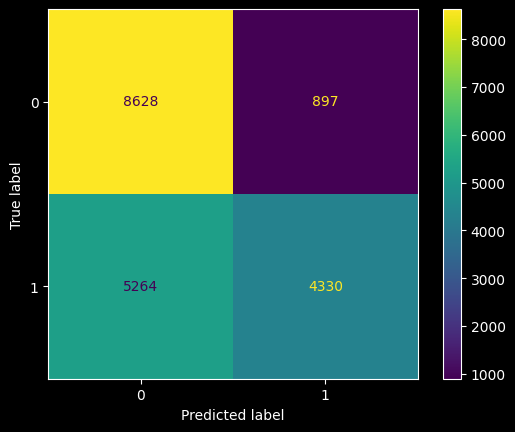

In [9]:
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see , the GNB Classifier performs really well on detecting the 'no' samples (true negatives), but does really bad on predicting the 'yes' samples (true positives) , as the size of the false negatives is larger than the true positives , whereas the false positives are a lot less compared to true negatives.

I will try to use a Support Vector Machine classifier now.In order to use this classifier , we have to convert our dataset to a numeric representation.
I will use PCA once again to accomplish this.

In [10]:
pca = PCA(0.90)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print("The PCA components we need are: ",pca.n_components_)
t_d=pca.fit_transform(X)

The PCA components we need are:  13


In [11]:
X_train,X_test,y_train,y_test=train_test_split(t_d,y,test_size=0.3,random_state=42)

In [12]:
from sklearn import svm
svm_classifier=svm.SVC()
svm_classifier.fit(X_train,y_train)

SVC()

After we train the classifier , we once again check how it performed based on accuracy and f1-score.

In [13]:
y_pred=svm_classifier.predict(X_test) 

print("The Accuracy of the SVM Classifier is : ",accuracy_score(y_test,y_pred))
print("The f1-score of the SVM Classifier is : ",f1_score(y_test,y_pred))

The Accuracy of the SVM Classifier is :  0.7426643652910717
The f1-score of the SVM Classifier is :  0.7058471840248713


We also need to check the confusion matrix once again to determine if the classifier performed well on both classes.

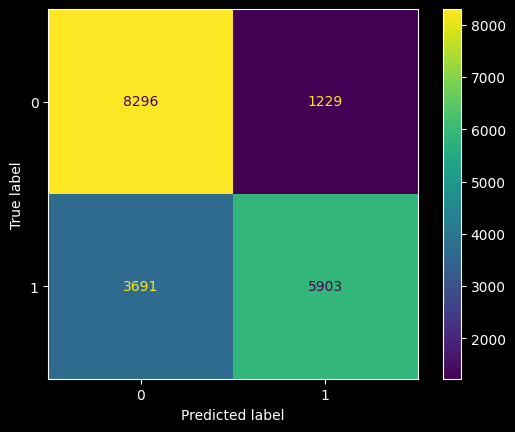

In [14]:
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see , the SVM classifier performed much better , by improving the true positive to false negative ratio , while at the same time it didnt change the true negative false positive ratio that much.